In [7]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.extensions import HamiltonianGate
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
from qiskit.quantum_info import Statevector, Operator
from qiskit.opflow import CircuitStateFn
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import scipy 
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [70]:
## import optimisers
from qiskit.algorithms.optimizers import COBYLA
from scipy.optimize import minimize

In [37]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


ibmqfactory.load_account:WARNING:2022-06-24 11:26:46,255: Credentials are already in use. The existing account in the session will be replaced.


## Variational Grover Search 
Here my aim is to train a variational circuit to reproduce the action of a Grover operator following the research article in https://arxiv.org/pdf/1805.09337.pdf


In [3]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ Convert a given pattern to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle.Gate    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    """ Gnerate the Diffuser operator for the case where the initial state  is 
        the equal superposition state of all basis vectors 
        input: l= no. of qubits
        output: diffuser.Gate    """
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    """ Run full Grover iteration for given number of steps.
        input:
        qc: QuantumCiruit to append to 
        oracles: a list of oracles generated from 'to_oracle()' function 
        diffuser: a diffuser from 'diffuser()' function 
        steps: no. of grover iterates"""
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc

def run(patterns, grover_steps ):
    
    dim = len(patterns[0])
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)
    # create circuit ~\
    
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    creg = ClassicalRegister(dim)
    qc = QuantumCircuit(qreg, creg, ancilla)
    qc.h(qreg)
    # run grover update steps ~\
    grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
    qc.measure(qreg, creg)
    
    job = execute(qc, backend= aer, shots= 1024)
    plot_histogram(job.result().get_counts())
    
    return qc, job



In [32]:
def var_grover_projectors(patterns, init = 'all+'):
    """ returns projectors on the good states and the initial state
         Input: 
            patterns= list of states in string form . Eg. ['000', '101']
            init= iniial state"""
    ## construct projector on good states
    
    states_good = []
    for pattern in patterns:
        stvc = Statevector.from_label(pattern)
        states_good.append(stvc)
    projector_good = states_good[0].to_operator()
    for i in range(1,len(states_good)):  projector_good = projector_good + states_good[i].to_operator()
    if init== 'all+': projector_init =  Statevector.from_label('+'*(stvc.num_qubits  ))
        

    # alpha, beta = 1, 1
    # unitary_good = HamiltonianGate(projector_good, -1*alpha, label='U_good')
    # unitary_init = HamiltonianGate(projector_init, -1*beta, label= 'U_init')


    return projector_init, projector_good


In [92]:
def var_grover_circuit(patterns, params,  init= 'all+', init_state_prep = None, method= 'stv', shots= 1024):

    p = len(params)//2
    alphas = params[:p]
    betas = params[p:]
    
    if len(alphas) != len(betas):
        raise ValueError("alpha beta has incompatible length")

    nq = len(patterns[0])
    qreg = QuantumRegister(nq , name= 'qreg')
    creg = ClassicalRegister(nq , name= 'creg')
    qc = QuantumCircuit(qreg, creg)
    
    if init== 'all+': qc.h(qreg)
    ## todo: add generalizability to prepare init state arbitraliy
    
    projector_init, projector_good = var_grover_projectors(patterns, init= 'all')
    unitary_good = [ HamiltonianGate(projector_good, -1*alpha, label='U_good: '+ str(alpha)) for alpha in alphas ]
    unitary_init = [ HamiltonianGate(projector_init, -1*beta, label= 'U_init: '+ str(beta)) for beta in betas]

    for p in range(len(alphas)):
        qc = qc.compose(unitary_good[p])
        qc = qc.compose(unitary_init[p])

    return qc


In [81]:
def var_grover_get_expectation( params, patterns ,method= 'stv', shots= 1024):
    p = len(params)//2
    alphas = params[:p]
    betas = params[p:]
    
    if len(alphas) != len(betas):
        raise ValueError("alpha beta has incompatible length")
    
    projector_init, projector_good = var_grover_projectors(patterns)
    qc = var_grover_circuit(patterns, params)

    if method == 'stv' :
        job = execute(qc, backend= stv, shots= shots)
        state = job.result().get_statevector()
        # state = CircuitStateFn(qc)
        op = Operator(np.identity(2**nq)) - projector_good
        exp_op = state.expectation_value(op)
    ## todo: add genralisation for method= 'counts' for counts based calculation of 'exp_op'
    
    return exp_op


In [82]:
patterns = [ '000', '111']
alphas, betas = [pi], [pi]
params = alphas + betas

In [83]:
len(patterns[0])

3

In [89]:
## optimization subroutine : qiskit
# optimizer = COBYLA(disp= True)
# optimizer.optimize(len(params), var_grover_get_expectation(params, patterns) , initial_point= params)

## optimization subroutine : scipy
steps = 1
result = minimize( var_grover_get_expectation, np.random.rand(2*steps) , (patterns, ) , method= 'COBYLA' )

/home/rajarsi/.local/lib/python3.10/site-packages/scipy/optimize/_cobyla_py.py:273: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


In [90]:
## trial ~ variational grover operator
qc = var_grover_circuit(patterns, result.x )
qc.draw()

┌───┐┌─────────────────────────────┐┌────────────────────────────┐
qreg_0: ┤ H ├┤0                            ├┤0                           ├
        ├───┤│                             ││                            │
qreg_1: ┤ H ├┤1 U_good: 3.2138859681330554 ├┤1 U_init: 3.214051807850305 ├
        ├───┤│                             ││                            │
qreg_2: ┤ H ├┤2                            ├┤2                           ├
        └───┘└─────────────────────────────┘└────────────────────────────┘
creg: 3/══════════════════════════════════════════════════════════════════

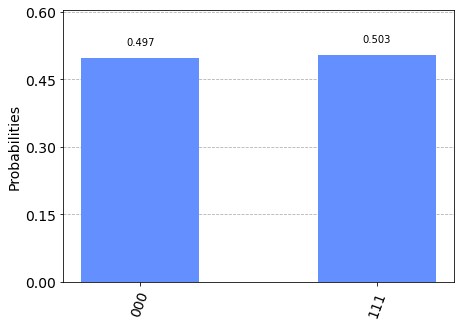

In [91]:
qc.measure(qreg, creg)
counts = execute(qc, backend= qsm, shots= 1024).result().get_counts()
plot_histogram(counts)
# counts

In [63]:
# patterns = [ '000', '111']
# # states_good = []
# # for pattern in patterns:
# #     stvc = Statevector.from_label(pattern)
# #     states_good.append(stvc)
# # projector_good = states_good[0].to_operator()
# # for i in range(1,len(states_good)):  projector_good = projector_good + states_good[i].to_operator()
# # alpha, beta = 1, 1
# # unitary_good = HamiltonianGate(projector_good, -1*alpha, label='U_good')
# # unitary_init = HamiltonianGate(projector_init, -1*beta, label= 'U_init')

# alphas, betas = [pi], [pi]
# params = alphas + betas
# # nq = len(patterns[0])
# # qreg = QuantumRegister(len(patterns[0]), name= 'qreg')
# # creg = ClassicalRegister(len(patterns[0]), name= 'creg')
# # qc = QuantumCircuit(qreg, creg)
# # qc.h(qreg)

# # # if init== 'all+': qc.h(qreg)
# # ## todo: add generalizability to prepare init state arbitraliy

# # projector_init, projector_good = var_grover_projectors(patterns)
# # unitary_good = [ HamiltonianGate(projector_good, -1*alpha, label='U_good: '+ str(alpha)) for alpha in alphas ]
# # unitary_init = [ HamiltonianGate(projector_init, -1*beta, label= 'U_init: '+ str(beta)) for beta in betas]

# # for p in range(len(alphas)):
# #     qc = qc.compose(unitary_good[p])
# #     qc = qc.compose(unitary_init[p])
# var_grover_get_expectation(params, patterns)


# # qc.draw()


(3.1643058896940347e-31+0j)

## scratch space

In [ ]:
unitary_good = HamiltonianGate(projector_good, -1*alpha, label='U_good')
unitary_init = HamiltonianGate(projector_init, -1*beta, label= 'U_init')

In [ ]:
p = -1*np.identity(4) + np.sin(pi/4)*np.identity(4) 
ui = HamiltonianGate(p, 1, label= '1')


In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.append(ui, [0,1])

qc.draw()

┌───┐┌────┐
q_0: ┤ H ├┤0   ├
     └───┘│  1 │
q_1: ─────┤1   ├
          └────┘

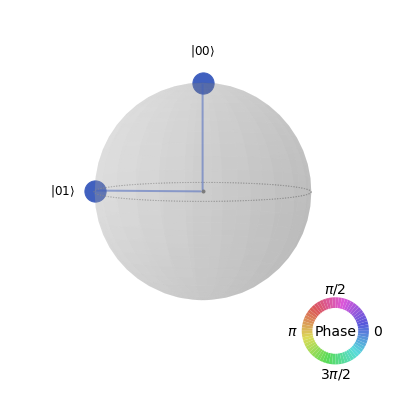

In [ ]:
plot_state_qsphere(qc)